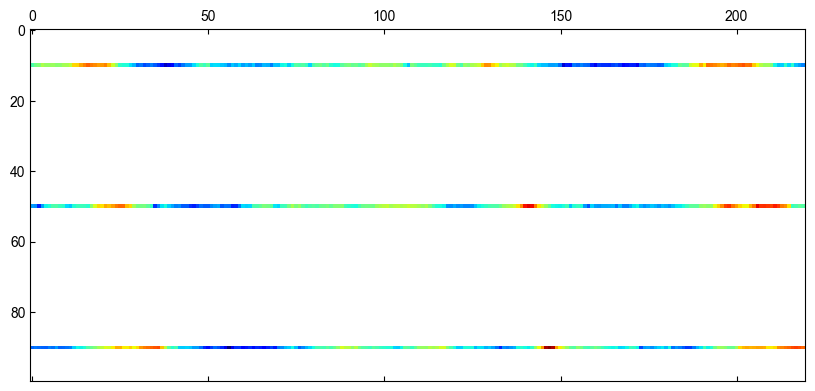

In [1]:
import numpy as np

from functions import *
path = '..//data//HighD//npy//'
full = np.load(path+'highD_full.npy')
full = fill_nan(full)

# Set detector location and plot it
d_loc = [10, 50, 90]
observed = np.NAN * np.zeros(full.shape)
observed[d_loc, :] = full[d_loc, :]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.matshow(observed, cmap='jet_r', vmax=full.max(), vmin=full.min())


HighD_detector_Directional_Matern52_N200_maxiter1500. theta: 0.142, lengthscale: [72.24325606  6.43933061], time: 20.591
Train mae: 1.610, rmse: 2.086. Test mae: 3.089, rmse: 4.046. Test mae2: 3.041, rmse2: 4.030.


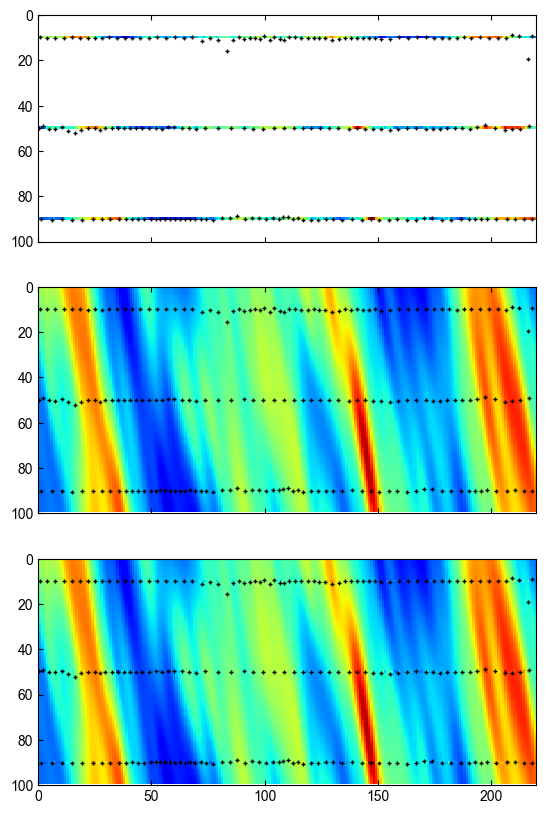

In [2]:
maxiter = 1500
mask = ~np.isnan(observed)
# n = min(max(int((~np.isnan(observed)).sum() * 0.02), 100), 500)  # number of inducing points
n=200
# rx = np.random.uniform(low=0, high=full.shape[1], size=(n,1))
# ry = np.random.uniform(low=0, high=full.shape[0], size=(n,1))
# plt.matshow(full, cmap='jet_r')

train_X = np.where(mask == 1)
train_Y = observed[train_X].reshape(-1, 1)
train_X = np.concatenate([x.reshape([-1, 1]) for x in train_X], axis = 1)
train_X = train_X.astype(np.float64)

mean_Y = np.mean(train_Y)
std_Y = np.std(train_Y)
train_Y  = (train_Y - mean_Y) / std_Y  # standardize
vmax = full.max()
vmin = full.min()

Z = np.random.permutation(train_X)[:n, :]  # inducing inputs
# Z = np.concatenate([ry, rx], axis=1).astype(np.float64)  # inducing inputs
kernel = Matern52
kernel = Directional_Kernel(kernel, lengthscales=[60.0, 13.0], theta=0.10, variance=0.2)
model = gpflow.models.SGPR(data=(train_X, train_Y), kernel=kernel, mean_function=None,
                           inducing_variable=Z, noise_variance=0.3)
# model.training_loss()
# print_summary(model)

# define monitor
test_name = f"HighD_detector_{model.kernel.name}_N{n}_maxiter{maxiter}"
# log_dir_compiled = "logs/fit/" + test_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_task = ModelToTensorBoard(log_dir_compiled, model)
# lml_task = ScalarToTensorBoard(
#     log_dir_compiled, lambda: model.training_loss(), "training_objective")
# Note that the `ImageToTensorBoard` task cannot be compiled, and is omitted from the monitoring
# monitor = Monitor(MonitorTaskGroup(lml_task))

time0 = time.time()
# print(f'Start training {test_name} at', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time0)))
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter),
                        # step_callback=monitor
                        )
# print(f'End training {test_name} at', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time.time())))

# Examine the results
test_X = np.where(full >= 0)
test_X = np.concatenate([x.reshape([-1, 1]) for x in test_X], axis=1)
test_X = test_X.astype(np.float64)
test_Y = model.predict_y(test_X)[0]

predicted_Y = test_Y.numpy().reshape(full.shape) * std_Y + mean_Y
predicted_Y2 = predicted_Y.copy()  # The prediction with observed location unchanged
predicted_Y2[mask] = observed[mask]

train_mae = mae(predicted_Y[mask], full[mask])
train_rmse = rmse(predicted_Y[mask], full[mask])
test_mae = mae(predicted_Y, full)
test_rmse = rmse(predicted_Y, full)
test_mae2 = mae(predicted_Y2, full)
test_rmse2 = rmse(predicted_Y2, full)

print(f'{test_name}. theta: {model.kernel.theta.numpy():.3f}, '
      f'lengthscale: {model.kernel.lengthscale.numpy()}, time: {time.time()-time0:.3f}')
print(f'Train mae: {train_mae:.3f}, rmse: {train_rmse:.3f}. Test mae: {test_mae:.3f}, rmse: {test_rmse:.3f}. '
      f'Test mae2: {test_mae2:.3f}, rmse2: {test_rmse2:.3f}.')


lengthscale = model.kernel.lengthscale.numpy()
test_name = test_name + f'_mae{test_mae:.3f}_rmse{test_rmse:.3f}' + \
            f'theta{model.kernel.theta.numpy():.3f}_lengthscale{lengthscale[0]:.3f}_{lengthscale[1]:.3f}'

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)
# ax[0].matshow(full, cmap='jet_r', vmax=vmax, vmin=vmin, origin='lower') # plot the full data
Z = model.inducing_variable.Z.numpy()
ax[0].matshow(observed,cmap='jet_r', vmax=vmax, vmin=vmin)  # plot the observed data
ax[0].scatter(Z[:,1], Z[:,0], c='k', s=10, marker='+', linewidths=1)
ax[1].matshow(predicted_Y,cmap='jet_r', vmax=vmax, vmin=vmin)  # plot the prediction
ax[1].scatter(Z[:,1], Z[:,0], c='k', s=10, marker='+', linewidths=1)
ax[2].matshow(predicted_Y2,cmap='jet_r', vmax=vmax, vmin=vmin)  # plot the observed data
ax[2].scatter(Z[:,1], Z[:,0], c='k', s=10, marker='+', linewidths=1)
ax[2].xaxis.set_ticks_position('bottom')
ax[2].set_xbound(0, full.shape[1])
ax[2].set_ybound(0, full.shape[0])

In [4]:
savemat(f'../result/outputs/detector_GP_rotated_HighD.mat', {'pre_mean': predicted_Y}, do_compression=True)